# Learning to create a Dataset, Dataloader and train a model

## 1. Downloading the data

In [3]:
!wget -O pneumonia.zip 'https://storage.googleapis.com/kaggle-data-sets/519943/964544/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1583169313&Signature=fhMELRil2nFCbJi%2FZeYFkJCea%2Fw8TDhhuEsS10rAPx1M0TxaXwdS2R2IZxYFKTM8m9DdUArN76LMdSnKY6W6X4LP7elMEyOvV1HrElSWPFORl63ndVaFlyAxsuhm23T9tls%2Fg3enJ%2FY8ljgl3gyK9cYrW2a7kiaU%2BXYjnIwHTOvxorzuyKZr2G9R9qW2CR9W0zHy56Ke0s5jldr7RCKq96dgKJPOceNBggBr%2BYiwpA5lLJRAnTzO8wdOy4WCwMm0BqGN%2BG2nxSRpLoa%2BoP6%2FiiutJZOUlrohxPQ%2FcPncM%2B8dfPDM9iJ%2FskrtQZeGu2L2Q4VcAL1DDNOMZiXKPX5E%2FQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dchest-xray-images-for-classification-pneumonia.zip'

--2020-02-28 17:15:54--  https://storage.googleapis.com/kaggle-data-sets/519943/964544/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1583169313&Signature=fhMELRil2nFCbJi%2FZeYFkJCea%2Fw8TDhhuEsS10rAPx1M0TxaXwdS2R2IZxYFKTM8m9DdUArN76LMdSnKY6W6X4LP7elMEyOvV1HrElSWPFORl63ndVaFlyAxsuhm23T9tls%2Fg3enJ%2FY8ljgl3gyK9cYrW2a7kiaU%2BXYjnIwHTOvxorzuyKZr2G9R9qW2CR9W0zHy56Ke0s5jldr7RCKq96dgKJPOceNBggBr%2BYiwpA5lLJRAnTzO8wdOy4WCwMm0BqGN%2BG2nxSRpLoa%2BoP6%2FiiutJZOUlrohxPQ%2FcPncM%2B8dfPDM9iJ%2FskrtQZeGu2L2Q4VcAL1DDNOMZiXKPX5E%2FQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dchest-xray-images-for-classification-pneumonia.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451790510 (2.3G) [application/zip]
Saving to: ‘pneumonia.zip’

pneumo

In [0]:
!unzip pneumonia.zip

In [5]:
!ls

pneumonia  pneumonia2  pneumonia.zip  sample_data


## 2. Creating the dataset and dataloader

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.95,1.05),contrast=(0.95,1.05),saturation=(0.95,1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [72]:
!ls pneumonia

test  train  validation


In [0]:
ds = {'train': datasets.ImageFolder('pneumonia/train',data_transforms['train']),
      'valid': datasets.ImageFolder('pneumonia/validation', data_transforms['val'])}

In [0]:
dl = {'train': torch.utils.data.DataLoader(ds['train'],batch_size=16,shuffle=True,num_workers=2),
      'valid': torch.utils.data.DataLoader(ds['valid'],batch_size=16,shuffle=True,num_workers=2)}

In [0]:
dataset_sizes = {x: len(ds[x]) for x in ['train', 'valid']}
class_names = ds['train'].classes

In [13]:
inputs, classes = next(iter(dl['train']))
inputs.shape, classes.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [14]:
inputs, classes = next(iter(dl['valid']))
inputs.shape, classes.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [0]:
def show_batch(dataloader,size = 8):

    inputs, classes = next(iter(dataloader))
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = inputs*std + mean
    #inputs = inputs.astype('uint8')
    w,h = size, size
    fig=plt.figure(figsize=(w, h))
    columns = 3
    rows = 2
    ax=[]
    for i in range(1, columns*rows +1):
        ax.append(fig.add_subplot(rows, columns, i))
        ax[-1].set_title('Class: '+str(classes[i].item()))
        plt.imshow((inputs[i]*255).astype(np.uint8))
    plt.show()

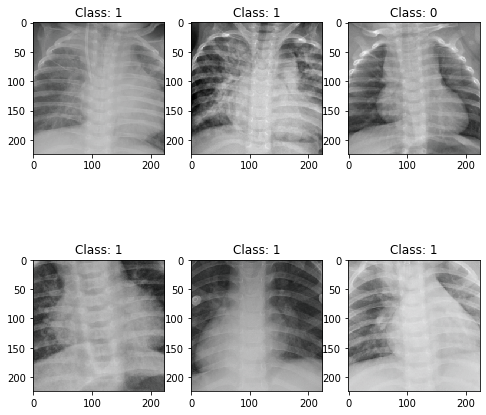

In [77]:
show_batch(dl['train'])

## 3. Creating and training a Model With fastai

In [0]:
mdl = models.resnet50(pretrained=True)

In [0]:
mdl.fc = nn.Linear(2048,2)

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
data = DataBunch(DataLoader(ds['train'],batch_size=16,shuffle=True,num_workers=2),DataLoader(ds['valid'],batch_size=16,shuffle=True,num_workers=2))

In [0]:
#making sure I'm not updating the weights for the conv layers
for child in mdl.children():
    for param in child.parameters():
        param.requires_grad = False

for param in mdl.fc.parameters():
    param.requires_grad=True

learn = Learner(data,mdl,loss_func=nn.CrossEntropyLoss(), metrics=[metrics.accuracy],callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.00E-02


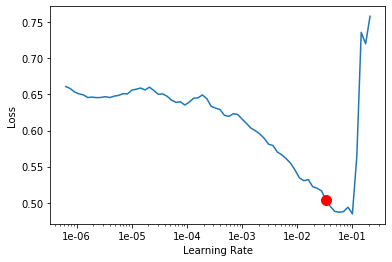

In [84]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.385878,0.745071,0.796928,01:17
1,0.347405,0.331225,0.908703,01:16
2,0.244464,0.188842,0.947952,01:17


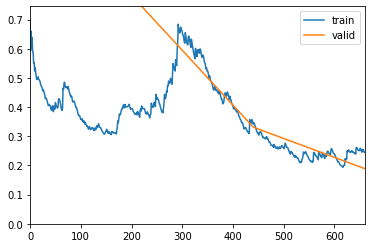

In [91]:
learn.fit_one_cycle(3,1e-2)

94.79% accuracy with 3min50s of training.


## 4. Creating and training a model with pure Pytorch

In [0]:
mdl = models.resnet50(pretrained=True)
mdl.fc = nn.Linear(2048,2)

In [0]:
#making sure I'm using a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
mdl = mdl.to(device)

#making sure I'm not updating the weights for the conv layers
for child in mdl.children():
    for param in child.parameters():
        param.requires_grad = False

for param in mdl.fc.parameters():
    param.requires_grad=True

criterion = nn.CrossEntropyLoss()

# Training only the fully connected layer
optimizer_ft = optim.AdamW(mdl.parameters(),lr=1e-2)

In [0]:
#using cyclic LRs and Momentuns
scheduler = lr_scheduler.CyclicLR(optimizer_ft,base_lr=1e-3,max_lr=1e-2,cycle_momentum=False)
#scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
#defining the training function
def fit_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #loss.requires_grad = True

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [106]:
mdl_fitted = fit_model(mdl, criterion, optimizer_ft, scheduler ,num_epochs=3)

Epoch 0/2
----------
train Loss: 0.2841 Acc: 0.8719
valid Loss: 0.1821 Acc: 0.9215

Epoch 1/2
----------
train Loss: 0.2278 Acc: 0.9044
valid Loss: 0.1708 Acc: 0.9292

Epoch 2/2
----------
train Loss: 0.1952 Acc: 0.9257
valid Loss: 0.1711 Acc: 0.9360

Training complete in 3m 52s
Best val Acc: 0.936007
